In [15]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F

In [16]:
torch.cuda.empty_cache()
# Paths
train_dir = "train"
valid_dir = "valid"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # Reduce a la mitad cada vez
        self.dropout = nn.Dropout(0.4)

        # Tamaño final: entrada 224x224 → 112x112 → 56x56 → 28x28 con 64 canales
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (B, 64, 28, 28)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
def train_manual(model, loader, optimizer, criterion):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

In [19]:
def validate_manual(model, loader, criterion):
    model.eval()
    total, correct, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    return val_loss, val_acc

In [20]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [21]:
train_dataset = ImageFolder("train", transform=transform_train)
valid_dataset = ImageFolder("valid", transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)

In [10]:
model = CustomCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(50):
    train_loss, train_acc = train_manual(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_manual(model, valid_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

Epoch 1: Train Loss=4.1602, Acc=0.0400 | Val Loss=4.0085, Acc=0.0771
Epoch 2: Train Loss=3.9220, Acc=0.0771 | Val Loss=3.7903, Acc=0.0814
Epoch 3: Train Loss=3.7500, Acc=0.1086 | Val Loss=3.6579, Acc=0.1014
Epoch 4: Train Loss=3.6071, Acc=0.1290 | Val Loss=3.5488, Acc=0.1143
Epoch 5: Train Loss=3.4980, Acc=0.1563 | Val Loss=3.4399, Acc=0.1414
Epoch 6: Train Loss=3.4018, Acc=0.1675 | Val Loss=3.3784, Acc=0.1700
Epoch 7: Train Loss=3.3124, Acc=0.1932 | Val Loss=3.3009, Acc=0.1914
Epoch 8: Train Loss=3.2370, Acc=0.2094 | Val Loss=3.2421, Acc=0.2057
Epoch 9: Train Loss=3.1717, Acc=0.2205 | Val Loss=3.2054, Acc=0.2200
Epoch 10: Train Loss=3.1044, Acc=0.2371 | Val Loss=3.1591, Acc=0.2029
Epoch 11: Train Loss=3.0601, Acc=0.2384 | Val Loss=3.1046, Acc=0.2129
Epoch 12: Train Loss=2.9975, Acc=0.2553 | Val Loss=3.0673, Acc=0.2314
Epoch 13: Train Loss=2.9546, Acc=0.2628 | Val Loss=3.0410, Acc=0.2414
Epoch 14: Train Loss=2.9026, Acc=0.2818 | Val Loss=2.9931, Acc=0.2357
Epoch 15: Train Loss=2.8592, 

In [11]:
import matplotlib.pyplot as plt

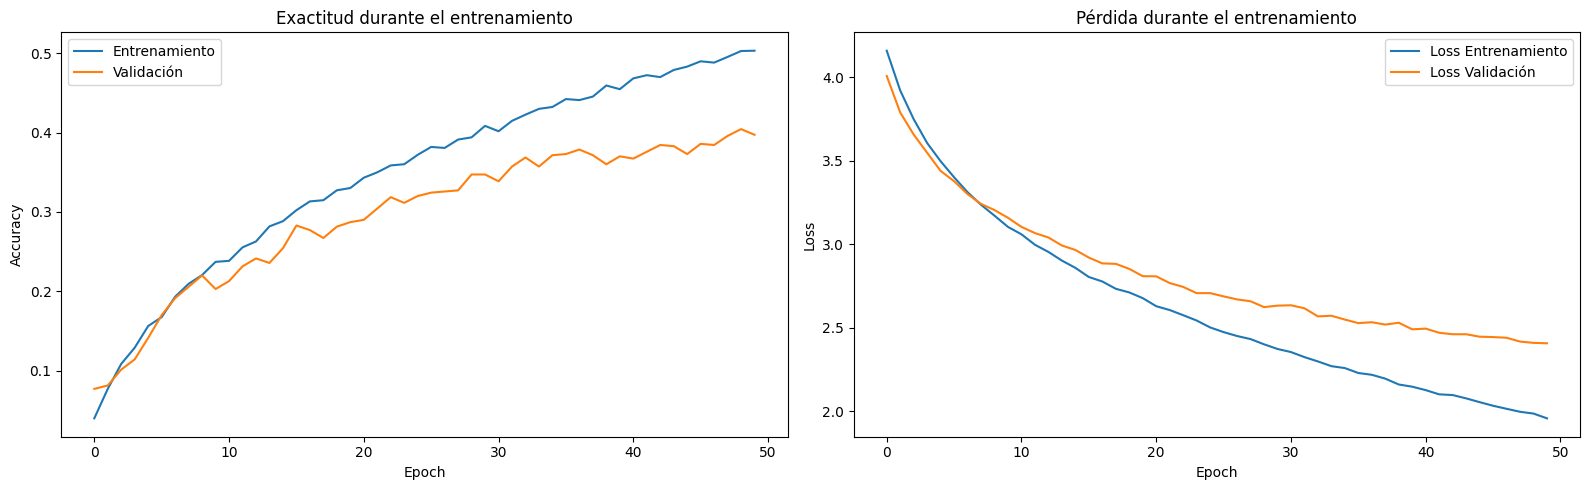

In [12]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento')
plt.plot(history['val_acc'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Loss Entrenamiento')
plt.plot(history['val_loss'], label='Loss Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("cnn_custom_resultados.png")
plt.show()

In [ ]:
model = CustomCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(50):
    train_loss, train_acc = train_manual(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_manual(model, valid_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

Epoch 1: Train Loss=4.2527, Acc=0.0208 | Val Loss=4.2317, Acc=0.0300
Epoch 2: Train Loss=4.2153, Acc=0.0306 | Val Loss=4.2006, Acc=0.0429
Epoch 3: Train Loss=4.1856, Acc=0.0332 | Val Loss=4.1649, Acc=0.0443
Epoch 4: Train Loss=4.1510, Acc=0.0438 | Val Loss=4.1292, Acc=0.0529
Epoch 5: Train Loss=4.1110, Acc=0.0485 | Val Loss=4.0940, Acc=0.0543
Epoch 6: Train Loss=4.0805, Acc=0.0593 | Val Loss=4.0584, Acc=0.0657
Epoch 7: Train Loss=4.0459, Acc=0.0628 | Val Loss=4.0197, Acc=0.0643
Epoch 8: Train Loss=4.0077, Acc=0.0714 | Val Loss=3.9931, Acc=0.0600
Epoch 9: Train Loss=3.9813, Acc=0.0779 | Val Loss=3.9596, Acc=0.0771
Epoch 10: Train Loss=3.9484, Acc=0.0846 | Val Loss=3.9305, Acc=0.0786
Epoch 11: Train Loss=3.9240, Acc=0.0843 | Val Loss=3.9051, Acc=0.0843
Epoch 12: Train Loss=3.8986, Acc=0.0904 | Val Loss=3.8673, Acc=0.0857
Epoch 13: Train Loss=3.8641, Acc=0.0969 | Val Loss=3.8488, Acc=0.0871
Epoch 14: Train Loss=3.8460, Acc=0.0993 | Val Loss=3.8141, Acc=0.0943
Epoch 15: Train Loss=3.8164, 

In [ ]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento')
plt.plot(history['val_acc'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Loss Entrenamiento')
plt.plot(history['val_loss'], label='Loss Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("cnn_custom_resultados.png")
plt.show()